In [2]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-10-01 15:09:12.609837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 15:09:13.961844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

## Config

In [4]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [5]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel agreement functions

In [6]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

### Channel level

In [7]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [8]:
pred_channels_wdice.to_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))
pred_channels_wkappa.to_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))

### Region level

Unnecessary replication here. I should just use pred_channels_wannots and then apply the region function to create pred_regions_wannots and then drop all the channel ones.

In [9]:
# TODO Unnecessary Cell?
# I should just go through eac
# Tranforming human annotations to regions
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()

In [10]:
# Transforming model predictions to regions
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique() if l != 'EmptyLabel'])
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals.astype(object)

In [11]:
predicted_channels.Patient.unique()

array(['HUP247', 'HUP253', 'HUP235', 'HUP249', 'HUP250', 'HUP263',
       'HUP230', 'HUP266', 'HUP238', 'HUP225', 'HUP224', 'HUP257',
       'HUP229', 'HUP246'], dtype=object)

In [12]:
predicted_channels[['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head(12)
# predicted_channels.loc[predicted_channels.Patient == 'CHOP005',['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head()

,Patient,iEEG_ID,model,threshold,ueo_rs_strict
15065,HUP247,HUP247_phaseII,NRG,0.65,right precuneus
15072,HUP247,HUP247_phaseII,NRG,0.72,right precuneus
15071,HUP247,HUP247_phaseII,NRG,0.71,right precuneus
15070,HUP247,HUP247_phaseII,NRG,0.70,right precuneus
15069,HUP247,HUP247_phaseII,NRG,0.69,right precuneus
15068,HUP247,HUP247_phaseII,NRG,0.68,right precuneus
15067,HUP247,HUP247_phaseII,NRG,0.67,right precuneus
15066,HUP247,HUP247_phaseII,NRG,0.66,right precuneus
15064,HUP247,HUP247_phaseII,NRG,0.64,right precuneus
15054,HUP247,HUP247_phaseII,NRG,0.54,right precuneus


In [13]:
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                        annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                        on='approximate_onset',by='Patient',
                                        tolerance = 240,
                                        direction='nearest',
                                        allow_exact_matches=True)
pred_regions_wannots.dropna(axis=0,subset='stim',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)

In [14]:
pred_regions_wannots[pred_regions_wannots.Patient == 'CHOP024']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs


In [15]:
def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','sec_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row
pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

In [16]:
pred_regions_wkappa.to_pickle(ospj(prodatapath,'predicted_regions_wkappa.pkl'))

## Channel Agreement Optimization

### DICE

In [17]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

In [18]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [19]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['HUP224', 'HUP225', 'HUP229', 'HUP230', 'HUP235', 'HUP238',
       'HUP246', 'HUP247', 'HUP249', 'HUP250', 'HUP253', 'HUP257',
       'HUP263', 'HUP266'], dtype=object)

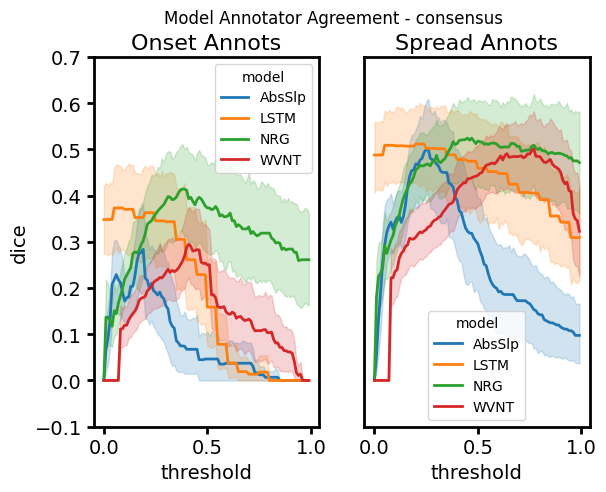

In [20]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((-.1,.7))
axs[0].set_title('Onset Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((-.1,.7))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('Spread Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

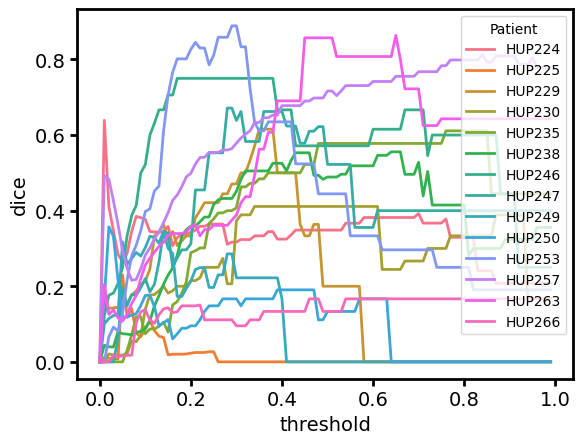

In [21]:
fig,ax = plt.subplots()
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'NRG')],x='threshold',y='dice',hue='Patient',errorbar=None,legend=True)
fig.savefig(ospj(figpath,f'pt_NRG_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

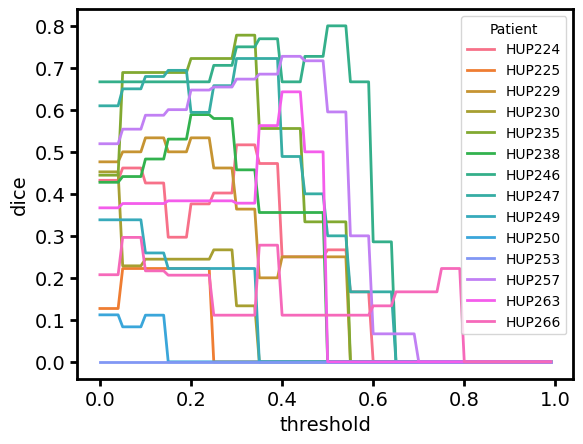

In [22]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='dice',hue='Patient',errorbar=None,)

### Kappa

In [26]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [27]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_loose_any_kappa' 'sec_chs_loose_bool'
 'sec_chs_loose_consensus_kappa' 'sec_chs_strict'
 'sec_chs_strict_any_kappa' 'sec_chs_strict_bool'
 'sec_chs_strict_consensus_kappa' 'sec_consensus' 'stim' 'threshold'
 'to_annotate' 'ueo_any' 'ueo_chs_loose' 'ueo_chs_loose_any_kappa'
 'ueo_chs_loose_bool' 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,sec_chs_loose_bool,sec_chs_loose_consensus_kappa,sec_chs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[True, True, True, True, True, True, True, Fal...",0.267516,0.306455,"[True, True, True, True, True, True, False, Fa...",0.477558,"[True, True, True, True, True, True, True, Fal...",0.337949,0.43282,ueo_chs_strict_consensus_kappa,0.33526
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[False, False, False, False, False, False, Fal...",0.000000,0.000000,"[False, False, False, False, False, False, Fal...",0.000000,"[False, False, False, False, False, False, Fal...",0.000000,0.00000,ueo_chs_strict_consensus_kappa,0.00000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[False, False, False, False, False, False, Fal...",0.240088,0.436827,"[False, False, False, False, False, False, Fal...",0.110366,"[False, False, False, False, False, False, Fal...",0.129887,0.21001,ueo_chs_strict_consensus_kappa,0.28035


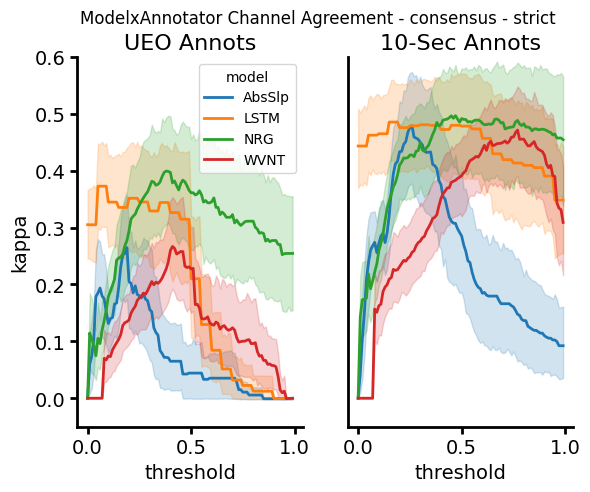

In [28]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.despine(ax=axs[0])
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
sns.despine(ax=axs[1])
fig.suptitle(f'ModelxAnnotator Channel Agreement - {anntype} - {mdl_anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_agreement_{anntype}-{mdl_anntype}.pdf'),transparent=True)

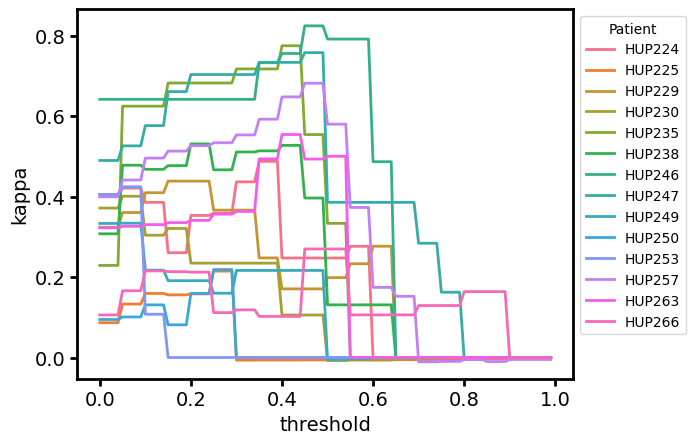

In [29]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM')],x='threshold',y='kappa',hue='Patient',errorbar=None,)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Getting optimal threshold

In [10]:
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [9]:
mask = mdl_preds_sorted.model == 'NRG'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')[f'ueo_{anntype}_{mdl_anntype}_dice'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')[f'sec_{anntype}_{mdl_anntype}_dice'].mean()

In [10]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean([ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()]]))

0.38
0.45
0.41500000000000004


## Region Agreement Optimization

### Kappa

In [32]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_regions_wkappa.pkl"))
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [33]:
mdl_preds_sorted[[col for col in mdl_preds_sorted.columns if 'kappa' in col]].fillna(0,inplace=True)
melt_cols = [f'ueo_rs_{mdl_anntype}_{anntype}_kappa',f'sec_rs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.364964,0.292683,0.292683,0.466258,0.317647,0.414986,ueo_rs_strict_consensus_kappa,0.364964
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ueo_rs_strict_consensus_kappa,0.000000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",1.000000,1.000000,1.000000,0.364964,0.472727,0.364964,ueo_rs_strict_consensus_kappa,1.000000


In [34]:
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'ueo_rs_strict',
       'ueo_rs_loose', 'sec_rs_strict', 'sec_rs_loose', 'all_rs',
       'ueo_consensus_rs', 'ueo_any_rs', 'sec_consensus_rs', 'sec_any_rs',
       'ueo_rs_strict_consensus_kappa', 'ueo_rs_strict_any_kappa',
       'ueo_rs_loose_consensus_kappa', 'ueo_rs_loose_any_kappa',
       'sec_rs_strict_consensus_kappa', 'sec_rs_strict_any_kappa',
       'sec_rs_loose_consensus_kappa', 'sec_rs_loose_any_kappa'],
      dtype='object')

Text(0.5, 0.98, 'ModelxAnnotator Region Agreement - consensus - strict')

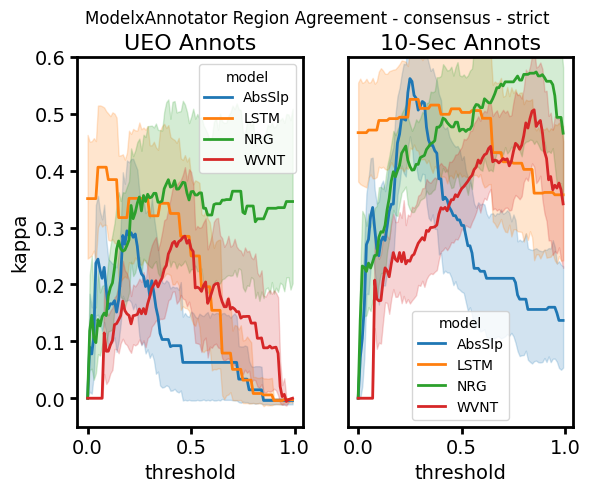

In [35]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'ModelxAnnotator Region Agreement - {anntype} - {mdl_anntype}')

In [36]:
mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
14800,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14801,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.364964,0.292683,0.292683,0.466258,0.317647,0.414986,sec_rs_strict_consensus_kappa,0.359621
14802,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14803,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,[],[],[],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
14804,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.01,[RB03],"[RB03, RB04]",[RB03],...,"[ left hippocampus , right hippocampus , rig...","[ left hippocampus , right hippocampus , rig...",1.000000,1.000000,1.000000,0.364964,0.472727,0.364964,sec_rs_strict_consensus_kappa,0.472727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29595,HUP266,HUP266_phaseII,WVNT,0.0,418859.4191,418859.4191,0.98,[],[],"[RB02, RC02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.594595,0.594595,0.594595,sec_rs_strict_consensus_kappa,0.594595
29596,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,0.99,[],[],[],...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
29597,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,0.99,[],[],"[RC02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.328358,0.328358,0.328358,sec_rs_strict_consensus_kappa,0.328358
29598,HUP266,HUP266_phaseII,NRG,0.0,418859.4191,418859.4191,0.99,[],[],"[RB01, RB02, RC03]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.594595,0.594595,0.594595,sec_rs_strict_consensus_kappa,0.594595


### Getting optimal threshold

In [1]:
mask = mdl_preds_sorted.model == 'NRG'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_rs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_rs_strict_consensus_kappa'].mean()

NameError: name 'mdl_preds_sorted' is not defined

In [38]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean((ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()])))

0.19
0.25
0.22


In [39]:
sum((mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM'))

3700

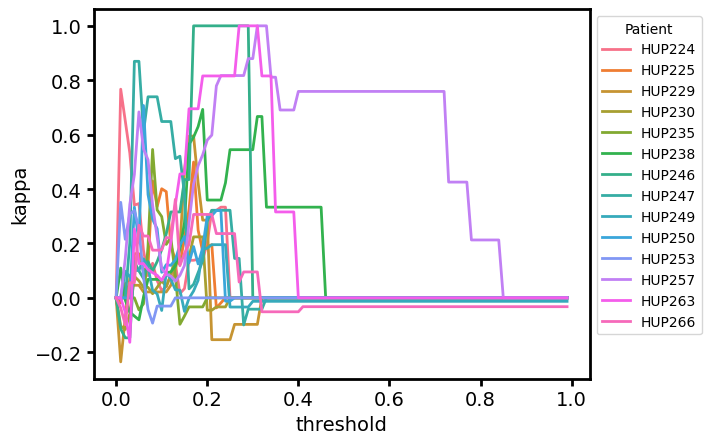

In [40]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'AbsSlp')],x='threshold',y='kappa',hue='Patient',errorbar=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KDE Model Predictions

In [23]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"kde_predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [30]:
pred_channels_wannots.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,to_annotate,all_chs,ueo_consensus,ueo_any,sec_consensus,sec_any
76,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.656919,[],[],"[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...",1.0,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
77,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,32.005471,[],[],[],[],1.0,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
78,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.223800,[],[],"[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",1.0,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
79,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.228114,"[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB01, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...",1.0,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
128,HUP224,HUP224_phaseII,LSTM,0.0,491467.8046,491467.8046,0.212606,"[LA01, LB01, LB02, LB03, LB05, LB06, LC01, LC0...","[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA09, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",1.0,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."


<Axes: xlabel='model', ylabel='ueo_consensus_strict_dice'>

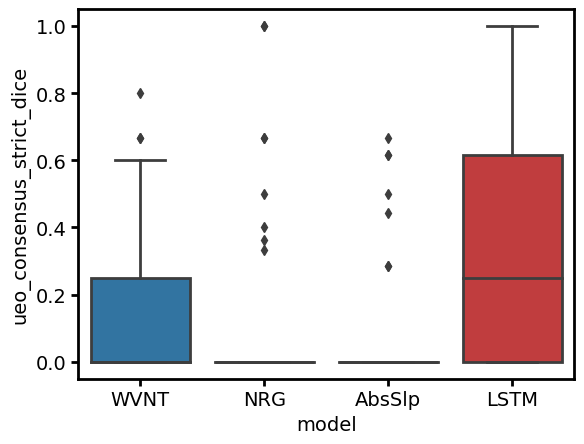

In [29]:
sns.boxplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice')